## Digital soil mapping of clay content

In this tutorial, my goal is to present an easy way to estimate clay content using digital soil mapping approaches. For this, a dataset with n samples with the clay content determined in the laboratory will be used as the target variable to be predicted over an area of n ha. As features, a median reflectance satellite image (Landsat) representing the bare surfaces will be used and a set of spectral indices calculated from Sentinel-2 mean reflectance images from the dry and moist seasons.

In [8]:
## Install libraries
!pip install seaborn

In [32]:
### Load libraries
import geopandas as gp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point


In [15]:
### Load dataset
dat_clay = pd.read_csv('DSM_clay/dataset.csv', sep=';')
dat_clay.head()

,X,Y,Clay.gkg,OM.gkg
0,-47.431591,-22.773409,301,22.21
1,-47.449435,-22.841908,503,25.02
2,-47.378210,-22.856072,120,15.00
3,-47.375972,-22.864430,128,8.00
4,-47.372973,-22.868192,117,11.00


In [17]:
### Basic statistics of the target variable
dat_clay.describe().T.style

,count,mean,std,min,25%,50%,75%,max
X,388.000000,-47.405859,0.028572,-47.457000,-47.429812,-47.402296,-47.384326,-47.345924
Y,388.000000,-22.865197,0.029960,-22.907360,-22.889000,-22.874463,-22.842459,-22.773409
Clay.gkg,388.000000,267.840206,161.258360,13.000000,124.000000,234.500000,418.500000,638.000000
OM.gkg,388.000000,18.600335,6.365130,5.800000,13.200000,17.900000,23.025000,39.000000


Text(0, 0.5, 'Frequency')

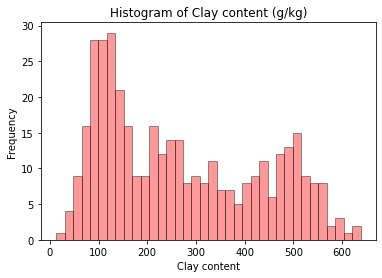

In [30]:
### Plotting histograms and density plots
sns.distplot(dat_clay['Clay.gkg'], hist = True, kde = False, bins = int(180/5), color = 'red', hist_kws = {'edgecolor': 'black'})
plt.title('Histogram of Clay content (g/kg)')
plt.xlabel('Clay content')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

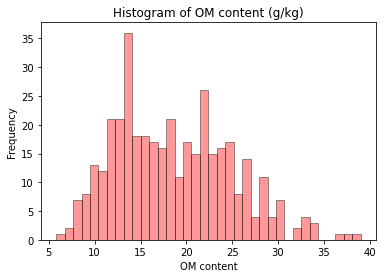

In [31]:
### Plotting histograms and density plot
sns.distplot(dat_clay['OM.gkg'], hist = True, kde = False, bins = int(180/5), color = 'red', hist_kws = {'edgecolor': 'black'})
plt.title('Histogram of OM content (g/kg)')
plt.xlabel('OM content')
plt.ylabel('Frequency')

           X          Y  Clay.gkg  OM.gkg                     geometry
0 -47.431591 -22.773409       301   22.21  POINT (-47.43159 -22.77341)
1 -47.449435 -22.841908       503   25.02  POINT (-47.44944 -22.84191)
2 -47.378210 -22.856072       120   15.00  POINT (-47.37821 -22.85607)
3 -47.375972 -22.864430       128    8.00  POINT (-47.37597 -22.86443)
4 -47.372973 -22.868192       117   11.00  POINT (-47.37297 -22.86819)


C:\Users\FREY\anaconda3\envs\gp_environ\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


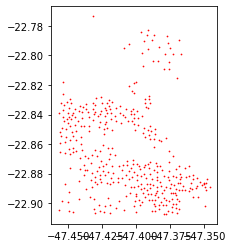

In [41]:
## Convert pandas dataframe into geopandas
geo = [Point(xy) for xy in zip(dat_clay['X'], dat_clay['Y'])]
CRS = {'init': 'epsg:4326'}
dat_clay_gpd = gp.GeoDataFrame(dat_clay, crs=CRS, geometry=geo)
print(dat_clay_gpd.head())
dat_clay_gpd.plot(marker='o', color = 'red', markersize = 0.5)
plt.show()

In [5]:
area = gp.read_file('DSM_clay/area_2_temp.shp')
print (area)

       MINX     MINY      MAXX      MAXY      CNTX      CNTY     AREA  \
0 -47.45702 -22.9075 -47.30045 -22.77282 -47.37873 -22.84016  0.02109   

     PERIM   HEIGHT    WIDTH  \
0  0.58251  0.13468  0.15657   

                                            geometry  
0  POLYGON ((-47.45702 -22.90750, -47.45702 -22.7...  
